In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint

# Import the relevant models - random forest and others for comparison:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


In [5]:
ww = pd.read_csv('C:\Asus WebStorage\psabin@gmail.com\MySyncFolder\Data Science Course\BlueBerry Winery\winequality-white.csv', sep=';')
red_wine = pd.read_csv('C:\Asus WebStorage\psabin@gmail.com\MySyncFolder\Data Science Course\BlueBerry Winery\winequality-red.csv', sep=';')

In [6]:
ww['quality_label'] = ww['quality'].apply(lambda value: 'low'
if value <= 5 else 'medium'
if value <= 6 else 'high')

red_wine['quality_label'] = red_wine['quality'].apply(lambda value: 'low'
if value <= 5 else 'medium'
if value <= 6 else 'high')

# here we are transforming these labels into categrical data type (specific to pandas) instead of simple string
red_wine['quality_label'] = pd.Categorical(red_wine['quality_label'],
categories=['low', 'medium', 'high'])

# here we are transforming these labels into categrical data type (specific to pandas) instead of simple string
ww['quality_label'] = pd.Categorical(ww['quality_label'],
categories=['low', 'medium', 'high'])

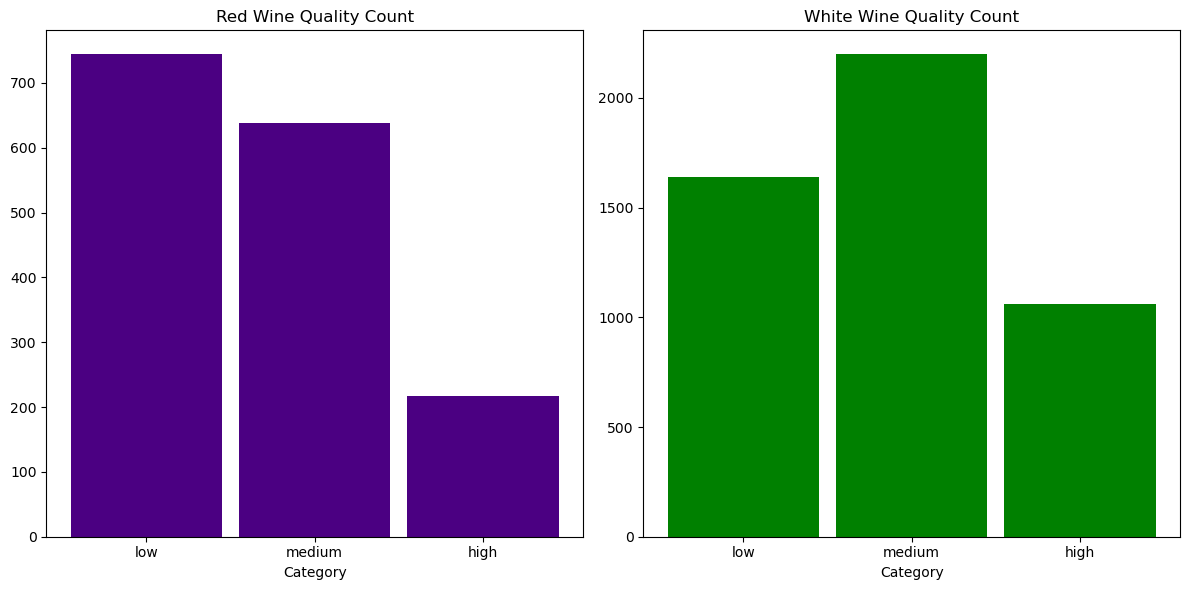

In [8]:
# Get counts for red wine
red_count_series = red_wine['quality_label'].value_counts().reindex(['low', 'medium', 'high'])

# Get counts for white wine
white_count_series = ww['quality_label'].value_counts().reindex(['low', 'medium', 'high'])

# x and y coordinates for red and white wine
x_red = red_count_series.index
y_red = red_count_series.values

x_white = white_count_series.index
y_white = white_count_series.values

# Initialize subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart for Red Wine
axes[0].bar(x_red, y_red, width=0.9, color='indigo')
axes[0].set_title('Red Wine Quality Count')
axes[0].set_xlabel('Category')

# Bar chart for White Wine
axes[1].bar(x_white, y_white, width=0.9, color='green')
axes[1].set_title('White Wine Quality Count')
axes[1].set_xlabel('Category')

# Display plots
plt.tight_layout()
plt.show()

In [9]:

le = LabelEncoder()
ww['encoded_quality_label'] = le.fit_transform(ww['quality_label'])  


In [10]:
# Swap 0 for 3 to make the order make sense from low to high
ww['encoded_quality_label'].replace(0,3,inplace=True)

In [11]:
ww.drop(['quality_label'], axis=1, inplace=True)

In [12]:
ww.drop(['quality'], axis=1, inplace=True)
display(ww.head())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,encoded_quality_label
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,2
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,2
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,2
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,2
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,2


## Select the features to use as inputs

In [13]:
# Select ALL features
ww_select = ww.drop(['encoded_quality_label'], axis=1)

## Create column-vector for quality_label (y)

In [14]:
y_ww_quality = ww.encoded_quality_label
display(y_ww_quality.head())
display(y_ww_quality.shape)

0    2
1    2
2    2
3    2
4    2
Name: encoded_quality_label, dtype: int32

(4898,)

## Split into train and test data

In [15]:
ww_features_train, ww_features_test, ww_quality_train, ww_quality_test = train_test_split(ww_select,y_ww_quality,test_size=0.2, random_state=19)

## Scale wine features to even out their impact on the model

In [17]:

# Also try different methods of normalization/standardization
scaler = RobustScaler()
ww_features_train_scaled = scaler.fit_transform(ww_features_train)
ww_features_test_scaled = scaler.transform(ww_features_test)

In [23]:
best_params = {'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 50,
 'criterion': 'entropy',
 'bootstrap': True}

## Create a function with several ML models at once

In [25]:
def model_accuracy_comparison(X_train, y_train, X_test, y_test):
    # Create an array of classification models (classifiers)
    classifiers = [
        ('Random Forest Tuned Robust', RandomForestClassifier(**best_params)),
        ('Random Forest Tuned', RandomForestClassifier(n_estimators = 50, min_samples_split=2, min_samples_leaf=1, max_features='log2', max_depth=20, criterion = 'entropy', bootstrap=True, random_state = 0)),
        ('Random Forest', RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)),
        ('Decision Tree', DecisionTreeClassifier(criterion = 'gini', random_state = 0)),
        ('Neural Network', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, learning_rate_init=0.001, early_stopping=True, activation='relu', solver='adam', random_state=0)),
        
    ]
    # Create a figure to accommodate the heatmaps for each model
    fig, axs = plt.subplots(1, len(classifiers), figsize=(16, 3))
    
    metrics_df = pd.DataFrame(columns=['Classifier', 'Test Accuracy', 'Train Accuracy', 'Precision', 'Recall', 'F1-Score'])

    for idx, (name, clf) in enumerate(classifiers):
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_train)
        test_predictions = clf.predict(X_test)
        
        # Calculate metrics
        train_accuracy = (accuracy_score(y_train, train_predictions) * 100).round(2)
        test_accuracy = (accuracy_score(y_test, test_predictions) * 100).round(2)
        precision = (precision_score(y_test, test_predictions, average='weighted') * 100).round(2)
        recall = (recall_score(y_test, test_predictions, average='weighted') * 100).round(2)
        f1 = (f1_score(y_test, test_predictions, average='weighted') * 100).round(2)
        cohen_kappa = cohen_kappa_score(y_test, test_predictions).round(2)
        
        # Create confusion matrix and heatmap of it
        cm = confusion_matrix(y_test, test_predictions)

        # Create a mask for off-diagonal cells
        mask = np.ones_like(cm, dtype=bool)
        np.fill_diagonal(mask, 0)

        bleh_green_palette = sns.diverging_palette(70, 100, s=100, l=50, as_cmap=True)
        correct_cmap = sns.color_palette("viridis_r", as_cmap=True)
        green_palette = sns.color_palette(palette='Greens_d')
        summer_palette = sns.color_palette(palette='summer_r')
        incorrect_cmap = sns.color_palette("flare", as_cmap=True)

        
        # Plot the heatmap with the mask
        sns.heatmap(cm, annot=True, fmt="d", cmap=summer_palette, mask=mask, cbar=False, ax=axs[idx])
        sns.heatmap(cm, annot=True, fmt="d", cmap=incorrect_cmap, mask=~mask, cbar=False, ax=axs[idx], vmax=cm.max())
        axs[idx].set_title(name)
        axs[idx].set_xlabel('Predicted labels')
        axs[idx].set_ylabel('True labels')

        metrics_row = {
            'Classifier': name,
            'Test Accuracy': test_accuracy,
            'Train Accuracy': train_accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            "Cohen's Kappa": cohen_kappa
        }

        metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics_row])]).reset_index(drop=True)
        metrics_df = metrics_df.sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)
    
    # Display the heatmap visualization
    plt.tight_layout()
    plt.show()

    display(metrics_df)

Call the big function on white wine features (input) quality (output)

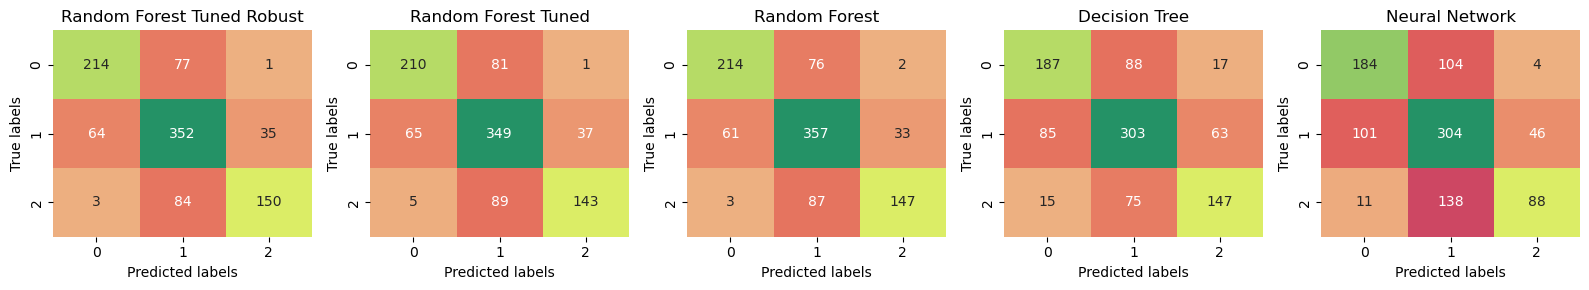

,Classifier,Test Accuracy,Train Accuracy,Precision,Recall,F1-Score,Cohen's Kappa
0,Random Forest,73.27,100.00,74.06,73.27,73.18,0.57
1,Random Forest Tuned Robust,73.06,100.00,73.77,73.06,73.02,0.57
2,Random Forest Tuned,71.63,100.00,72.40,71.63,71.54,0.55
3,Decision Tree,65.00,100.00,65.00,65.00,64.98,0.45
4,Neural Network,58.78,63.14,59.57,58.78,58.06,0.33


In [26]:
model_accuracy_comparison(ww_features_train_scaled, ww_quality_train, ww_features_test_scaled, ww_quality_test)

In [22]:
models_cross_val_df = model_cross_val(ww_features_train_scaled, ww_quality_train, ww_features_test_scaled, ww_quality_test)
display(models_cross_val_df)

,Classifier,Mean Accuracy,Standard Deviation
0,Random Forest,0.699,0.009
1,Decision Tree,0.619,0.013
2,Support Vector Classification,0.615,0.007
3,Neural Network,0.606,0.008
4,K Nearest Neighbors,0.589,0.014
5,Logistic Regression,0.576,0.012
6,Gaussian Naive Bayes,0.505,0.025
